# Data gathering

In [1]:
import numpy as np
from tpreviews import GetReviews #to use the tpreviews module place the tprevies.py file in the working directory
import pandas as pd
from afinn import Afinn

#ONLY EXECUTE ONCE!! We gathered the data on 24-08-2018

#d = GetReviews() 
#d['www.jensens.com'] = '469070ae0000640005000ddd'
#print(d)

In [2]:
#retured_dict = d.gather_data('dk') #Here we specify that we want reviews in Danish

### Save to .csv

In [3]:
#df = pd.DataFrame(retured_dict) 
#df.to_csv("Trustpilot_Jensens_180824.csv", index = False)

### Read .csv and remove the reviewer name

In [4]:
#data = pd.read_csv("Trustpilot_Jensens_180824.csv")

#remove the reviewer name and save again

#data = data.drop('reviewerName', axis = 1)
#data.to_csv("Trustpilot_Jensens_180824_nonames.csv", index = False)

#read the new data
data = pd.read_csv("Trustpilot_Jensens_180824_nonames.csv")

### Inspect the data

In [5]:
print(data.shape, '\n')
print(data.columns, '\n') #no reviewer name anymore!
print(data.dtypes, '\n')
print(data.head())

(3922, 6) 

Index(['headline', 'inLanguage', 'datePublished', 'reviewBody', 'ratingValue',
       'Company'],
      dtype='object') 

headline         object
inLanguage       object
datePublished    object
reviewBody       object
ratingValue       int64
Company          object
dtype: object 

                               headline inLanguage         datePublished  \
0  Helt fantastisk middagsoplevelse på…         da  2018-08-23T12:28:51Z   
1                        Fin til prisen         da  2018-08-22T11:16:41Z   
2                           God service         da  2018-08-22T11:14:21Z   
3                 Ganske fin til prisen         da  2018-08-22T11:13:58Z   
4                       Skidt oplevelse         da  2018-08-22T06:25:14Z   

                                          reviewBody  ratingValue  \
0  Helt fantastisk middagsoplevelse på Jensens Bø...            5   
1         Ganske fin mad og okay service til prisen.            3   
2  Ok god service. Bøffen var lidt saltet 

<br><br><br><br>
# Data Description

<br><br>
## Compute new variables for descriptives and analysis

### Get the Afinn scores for each review

In [6]:
afinn = Afinn()
scores = [] #initiate score list

for i in range(0, data.shape[0]):
    score = afinn.score(str(data['reviewBody'].iloc[i])) #Compute an afinn score for each review in the dataset
    scores.append(score) #Append score to score list

data['Afinn_score'] = scores #Create a new variable with the afinn scores in our dataset
data['Afinn_binary'] = data['Afinn_score'].apply(lambda x: 1 if x>0 else 0) #Dichotomize  
#(perhaps determine cutpoint where afinn score has rating 3?--> no then fit will be perfect for afinn....)

In [7]:
data['Afinn_binary'].describe() #See if dichotomization worked

count    3922.000000
mean        0.188169
std         0.390897
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Afinn_binary, dtype: float64

### Other variables

In [8]:
#First compute time variables
data['datetime'] = pd.to_datetime(data['datePublished'].astype(str))
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day

#convert ratings to -1, 0, 1
def func(x):
    if  x <= 2:
        return -1
    elif x == 3:
        return 0
    return 1

data['rating_c'] = data['ratingValue'].apply(func) #split in 3 
data['rating_binary'] = data['rating_c'].apply(lambda x: 1 if x>0 else 0) #dichotomize ratings to 0-1


#Set the index without throwing away variables
data.set_index(['year', 'month', 'day'], inplace = True, drop = False)

#Compute day means, dat sums, day counts, other variables
data['daymean_afinn'] = data.groupby(level=['year', 'month', 'day']).mean()['Afinn_score'] #daymean of Afinn_score
data['daymean_rating'] = data.groupby(level=['year', 'month', 'day']).mean()['rating_c'] #daymean of ratings
data['no_rev'] = data.groupby(level=['year', 'month', 'day']).count()['reviewBody'] #number of reviews per day
data['len_rev'] = data['reviewBody'].apply(len) #length of a review
data['daysum_afinn'] = data.groupby(level=['year', 'month', 'day']).sum()['Afinn_score'] #compute summed dayscore
data['daysum_rating'] = data.groupby(level=['year', 'month', 'day']).sum()['rating_c'] 

#Make a variable indicating whether the review is from sept 2014, before and after.
data['sept14'] = ((data['datetime'] > '2014-08-31') & (data['datetime'] < '2014-10-01')).replace(False, 0)
data['before_sept14'] = (data['datetime'] < '2014-09-01').replace(False, 0)
data['after_sept14'] = (data['datetime'] > '2014-09-30').replace(False, 0)

print(data['sept14'].describe()) #35.9% of all reviews written in sept 2014
print(data['before_sept14'].describe())#26% of all reviews written before sept 2014
print(data['after_sept14'].describe())#38% of all review written after sept 2014


#Create categorical variable with before during and after 2014 values
time = data[['before_sept14', 'sept14', 'after_sept14']].idxmax(axis=1)
time = time.astype(dtype = 'category')

time = time.cat.rename_categories(['After Sept 2014', 'Before Sept 2014', 'Sept 2014']) #rename categories
time= time.cat.reorder_categories(['Before Sept 2014', 'Sept 2014', 'After Sept 2014']) #reorder categories
data['time_cat'] = time

count    3922.000000
mean        0.359001
std         0.479769
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: sept14, dtype: float64
count    3922.000000
mean        0.261346
std         0.439424
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: before_sept14, dtype: float64
count    3922.000000
mean        0.380418
std         0.485552
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: after_sept14, dtype: float64


<br><br><br><br>
## Descriptives and figures

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

### Get the cumulative mean of the ratings and plot those

C:\Users\Jolien\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


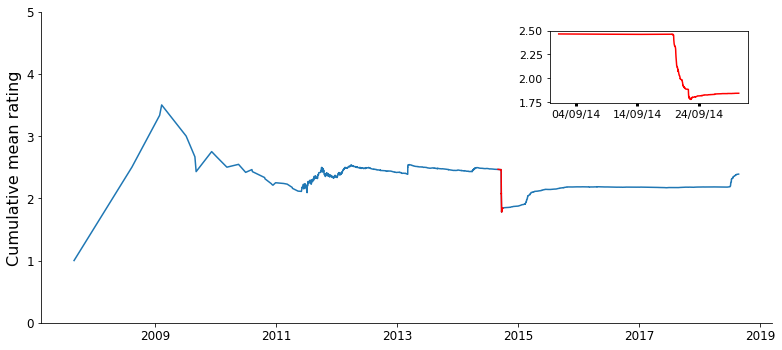

In [10]:
cum_mean = data.sort_values('datetime', ascending = True)['ratingValue'].expanding().mean()
cum_ratings =  data.sort_values('datetime', ascending = True).expanding().count()['headline']
data_sorted = data.sort_values('datetime', ascending = True)
data_sorted['cum_mean'] = cum_mean
data_sorted['cum_ratings'] = cum_ratings


# Creating variables for plots
data_sorted_sept = data_sorted[data_sorted["sept14"] == 1]
data_sorted_before = data_sorted[data_sorted['before_sept14'] == 1]
data_sortes_after = data_sorted[data_sorted['after_sept14'] == 1]

x1 = data_sorted["datetime"] #first figure
y1 = data_sorted["cum_mean"]
x2 = data_sorted_sept["datetime"] #second figure
y2 = data_sorted_sept["cum_mean"]

x3 = data_sorted["datetime"] #third figure
y3 = data_sorted["cum_ratings"]
x4 = data_sorted_sept["datetime"] #fourth figure
y4 = data_sorted_sept["cum_ratings"]


#creating canvas for figures
fig, ax1 = plt.subplots(1,1, figsize=(11,5))
plt.rcParams.update({'font.size': 11})


ax1.plot(x1,y1)
ax1.plot(x2, y2, color = 'red')
ax1.set_ylabel("Year", fontsize=16)
ax1.set_ylabel("Cumulative mean rating", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
plt.yticks([ 0, 1, 2, 3, 4, 5])
ax1.spines['top'].set_visible(False) #remove borders
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

plt.tight_layout()


myFmt = mdates.DateFormatter('%d/%m/%y')

ax2 = fig.add_axes([0.7, 0.7, 0.25, 0.2])
ax2.plot(x2, y2, color = 'red')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(ticker.MaxNLocator(4))

ax2.tick_params(
    axis='x',          
    which='both',     
    bottom=True,      
    top=False,         
    labelbottom=True, direction='out', length=3, width=3, labelrotation=0.12) 


plt.tight_layout()

fig.savefig("RatingTimeline.png")

### Get a plot of the cumulative number of reviews

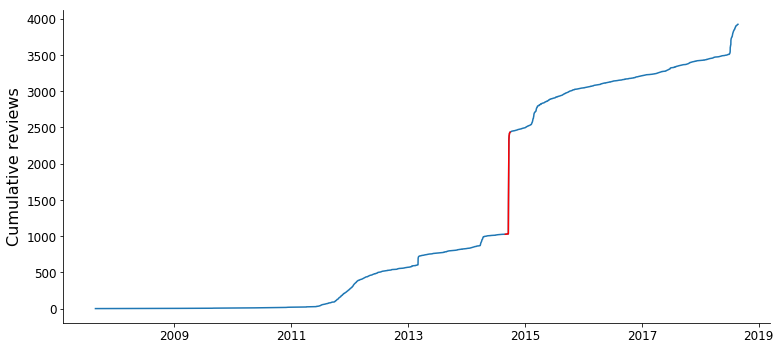

In [11]:
x1 = data_sorted["datetime"] #first figure
y1 = data_sorted["cum_ratings"]
x2 = data_sorted_sept["datetime"] #second figure
y2 = data_sorted_sept["cum_ratings"]


#creating canvas for figures
fig, ax1 = plt.subplots(1,1, figsize=(11,5))
plt.rcParams.update({'font.size': 11})


ax1.plot(x1,y1)
ax1.plot(x2, y2, color = 'red')
ax1.set_ylabel("Year", fontsize=16)
ax1.set_ylabel("Cumulative reviews", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
#plt.yticks([ 0, 1, 2, 3, 4, 5])
ax1.spines['top'].set_visible(False) #remove borders
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

plt.tight_layout()

fig.savefig("CumReviewsTimeline.png")

### Get the length of the reviews in characters grouped by rating and time period

In [12]:
data.groupby(['time_cat', 'rating_binary']).describe()['len_rev']

count        mean         std   min     25%  \
time_cat         rating_binary                                                 
Before Sept 2014 0               733.0  637.889495  584.204344  16.0  222.00   
                 1               292.0  232.643836  313.682238  13.0   73.00   
Sept 2014        0              1288.0  283.033385  337.119094  12.0   75.00   
                 1               120.0  203.683333  219.604227  14.0   68.75   
After Sept 2014  0               661.0  680.944024  614.563685  13.0  246.00   
                 1               828.0  211.143720  239.732474  12.0   67.75   

                                  50%     75%     max  
time_cat         rating_binary                         
Before Sept 2014 0              461.0  881.00  3790.0  
                 1              145.0  271.00  3770.0  
Sept 2014        0              168.0  354.25  3053.0  
                 1              130.5  247.00  1344.0  
After Sept 2014  0              514.0  932.00  4069.0  
                 1              134.5  265.25  2058.0

### Get the two days with the largest amount of reviews

In [13]:
data.groupby(['no_rev', 'year', 'month', 'day']).max()[-2:]
#error because groupby variables are both columns and indexes.

C:\Users\Jolien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
C:\Users\Jolien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'month' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
C:\Users\Jolien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'day' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,,,,Afinn_binary,Afinn_score,Company,after_sept14,before_sept14,datePublished,datetime,daymean_afinn,daymean_rating,daysum_afinn,daysum_rating,headline,inLanguage,len_rev,ratingValue,rating_binary,rating_c,reviewBody,sept14
no_rev,year,month,day,,,,,,,,,,,,,,,,,,,
458,2014,9,22,1,7.0,www.jensens.com,0.0,0.0,2014-09-22T22:40:58Z,2014-09-22 22:40:58,-1.327511,-0.792576,-608.0,-363,👍👍👍,da,3053,5,1,1,Øv oplevelse,1.0
484,2014,9,20,1,4.0,www.jensens.com,0.0,0.0,2014-09-20T23:52:31Z,2014-09-20 23:52:31,-1.324380,-0.929752,-641.0,-450,Øv med mere øv på.,da,2386,5,1,1,"Øv, Eat all can sparreribs eksistere ikke læng...",1.0


### Plot of reviews over time

C:\Users\Jolien\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


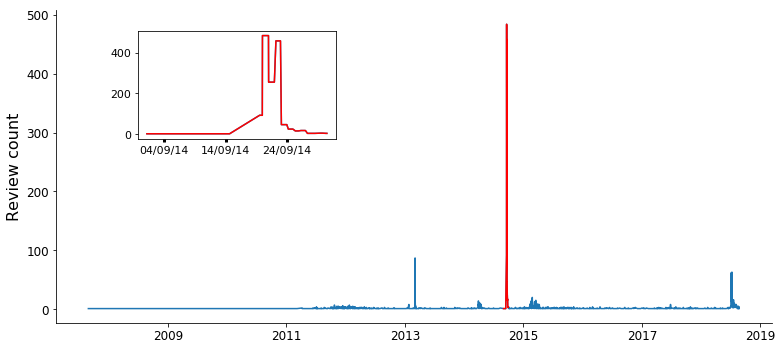

In [14]:
# Creating variables for plots
data_sept = data[data["sept14"] == 1]
data_before = data[data['before_sept14'] == 1]
data_after = data[data['after_sept14'] == 1]

x1 = data["datetime"] #first figure
y1 = data["no_rev"]
x2 = data_sept["datetime"] #second figure
y2 = data_sept["no_rev"]


#creating canvas for figures
fig, ax1 = plt.subplots(1,1, figsize=(11,5))
plt.rcParams.update({'font.size': 11})


ax1.plot(x1,y1)
ax1.plot(x2, y2, color = 'red')
ax1.set_ylabel("Year", fontsize=16)
ax1.set_ylabel("Review count", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False) #remove borders
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)


plt.tight_layout()

myFmt = mdates.DateFormatter('%d/%m/%y')

ax2 = fig.add_axes([0.18, 0.6, 0.25, 0.3])
ax2.plot(x2, y2)
ax2.xaxis.set_major_formatter(myFmt)
ax2.plot(x2, y2, color="red")
ax2.xaxis.set_major_locator(ticker.MaxNLocator(4))

ax2.tick_params(
    axis='x',          
    which='both',     
    bottom=True,      
    top=False,         
    labelbottom=True, direction='out', length=3, width=3, labelrotation=0.12) 

plt.tight_layout()

fig.savefig("ReviewTimeline.png")


### Get the increase/decrease in stars over time:

In [15]:
data.groupby(['time_cat', 'rating_binary', 'ratingValue']).describe()['no_rev'] #use the count column to get relative percentages

count        mean         std  \
time_cat         rating_binary ratingValue                                   
Before Sept 2014 0             1             379.0    4.709763   13.738302   
                               2             217.0    8.797235   20.855663   
                               3             137.0   14.948905   29.136929   
                 1             4             156.0   18.576923   31.644811   
                               5             136.0   14.169118   27.847350   
Sept 2014        0             1            1209.0  382.898263  143.879165   
                               2              63.0  337.015873  170.571382   
                               3              16.0  283.125000  219.433475   
                 1             4              26.0  232.153846  214.102722   
                               5              94.0  277.021277  205.998537   
After Sept 2014  0             1             438.0    2.979452    5.124718   
                               2             122.0    5.180328   11.224984   
                               3             101.0    8.099010   14.514479   
                 1             4             241.0   13.921162   18.439259   
                               5             587.0   14.328790   20.400326   

                                             min    25%    50%     75%    max  
time_cat         rating_binary ratingValue                                     
Before Sept 2014 0             1             1.0    1.0    2.0    3.00   87.0  
                               2             1.0    1.0    2.0    5.00   87.0  
                               3             1.0    2.0    3.0    7.00   87.0  
                 1             4             1.0    2.0    3.0   11.75   87.0  
                               5             1.0    2.0    3.0    8.00   87.0  
Sept 2014        0             1             1.0  255.0  458.0  484.00  484.0  
                               2            15.0  255.0  458.0  458.00  484.0  
                               3             3.0   17.0  458.0  458.00  484.0  
                 1             4             3.0   29.5   92.0  458.00  458.0  
                               5             3.0   46.0  458.0  458.00  484.0  
After Sept 2014  0             1             1.0    1.0    2.0    3.00   63.0  
                               2             1.0    1.0    2.0    4.00   63.0  
                               3             1.0    1.0    2.0    9.00   63.0  
                 1             4             1.0    3.0    8.0   15.00   63.0  
                               5             1.0    2.0    5.0   13.50   63.0

<br><br><br><br>
# Data Analysis

<br><br>
## Implement tokenization using TfidfVectorizor

### First split the data into training, test and validation sets

In [16]:
from sklearn.model_selection import train_test_split
import nltk

data_before_d, data_before_t, y_before_d, y_before_t = train_test_split(data_before, 
                                                                        data_before[['rating_binary', 'Afinn_binary']],
                                                                        test_size=0.3, random_state=1)

data_sept_d, data_sept_t, y_sept_d, y_sept_t = train_test_split(data_sept, 
                                                                data_sept[['rating_binary', 'Afinn_binary']],
                                                                test_size=0.3, random_state=1)

data_after_d, data_after_t, y_after_d, y_after_t = train_test_split(data_after, 
                                                                    data_after[['rating_binary', 'Afinn_binary']],
                                                                    test_size=0.3, random_state=1)    


#Extract the reviews from the split data
X_before_dev = data_before_d['reviewBody']
X_before_test = data_before_t['reviewBody']
X_sept_dev = data_sept_d['reviewBody']
X_sept_test = data_sept_t['reviewBody']
X_after_dev = data_after_d['reviewBody']
X_after_test = data_after_t['reviewBody']

#Split y_t and y_d into rating and afinn scores
y_dev_b = y_before_d['rating_binary']
y_test_b = y_before_t['rating_binary']
y_dev_d = y_sept_d['rating_binary']
y_test_d = y_sept_t['rating_binary']
y_dev_a = y_after_d['rating_binary']
y_test_a = y_after_t['rating_binary']

y_before_afinn_check_dev = y_before_d['Afinn_binary']
y_before_afinn_check_test = y_before_t['Afinn_binary']
y_sept_afinn_check_dev = y_sept_d['Afinn_binary']
y_sept_afinn_check_test = y_sept_t['Afinn_binary']
y_after_afinn_check_dev = y_after_d['Afinn_binary']
y_after_afinn_check_test = y_after_t['Afinn_binary']

#Check size of data before, during and after sept 2014
print(y_dev_b.shape)
print(y_test_b.shape)
print(y_dev_d.shape)
print(y_test_d.shape)
print(y_dev_a.shape)
print(y_test_a.shape)

(717,)
(308,)
(985,)
(423,)
(1044,)
(448,)


### Then tokenize

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def tokenizer(str_input):
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split() #only include words, no - or numbers or other special signs
    return words

vectorizer = TfidfVectorizer(preprocessor=None, tokenizer=nltk.word_tokenize)
#vectorizer = TfidfVectorizer(preprocessor=None, tokenizer=tokenizer)

vectorizer.fit(X_before_dev)
X_dev_vec_b = vectorizer.transform(X_before_dev)
X_test_vec_b = vectorizer.transform(X_before_test)
tokens_b = vectorizer.get_feature_names() #Get the individual tokens
print('Number of tokens before September 2014: ', len(tokens_b)) #Number of tokens

vectorizer.fit(X_sept_dev)
X_dev_vec_d = vectorizer.transform(X_sept_dev)
X_test_vec_d = vectorizer.transform(X_sept_test)
tokens_d = vectorizer.get_feature_names() #Get the individual tokens
print('Number of tokens during September 2014: ', len(tokens_d)) #Number of tokens

vectorizer.fit(X_after_dev)
X_dev_vec_a = vectorizer.transform(X_after_dev)
X_test_vec_a = vectorizer.transform(X_after_test)
tokens_a = vectorizer.get_feature_names() #Get the individual tokens
print('Number of tokens after September 2014: ', len(tokens_a)) #Number of tokens

Number of tokens before September 2014:  6238
Number of tokens during September 2014:  5059
Number of tokens after September 2014:  6941


<br><br>
## Define functions for algorithms

### Function to compute accuracy of a fitted model (binary outcome)

In [18]:
def A(fittedModel, X, y):
    
    y_pred = fittedModel.predict(X)

    TP = sum(np.where(y + y_pred == 2, 1, 0))
    TN = sum(np.where(y + y_pred == 0, 1, 0))
    FP = sum(np.where((y == 0) & (y_pred == 1), 1, 0))
    FN = sum(np.where((y == 1) & (y_pred == 0), 1, 0))
    
    ACC = (TP + TN) / (TP + TN + FP + FN)

    return(ACC)

def A_afinn(y_pred, y):
    
    TP = sum(np.where(y + y_pred == 2, 1, 0))
    TN = sum(np.where(y + y_pred == 0, 1, 0))
    FP = sum(np.where((y == 0) & (y_pred == 1), 1, 0))
    FN = sum(np.where((y == 1) & (y_pred == 0), 1, 0))
    
    ACC = (TP + TN) / (TP + TN + FP + FN)

    return(ACC)

### Define classifiers (binary outcome)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

logreg_lib = LogisticRegression(penalty = 'l1', C = 5, random_state = 1) #liberal regularization

#We have to set dual to False in order to get 'l1' penalty.
svc_lib = LinearSVC(penalty = 'l1', C = 5, random_state = 1, dual = False) #liberal regularization

NB = BernoulliNB()

<br><br>
## Compute accuracy of Afinn scores

In [20]:
print('Training accuracy Afinn score before September 2014: ', A_afinn(y_before_afinn_check_dev, y = y_dev_b))
print('Training accuracy Afinn score during September 2014: ', A_afinn(y_sept_afinn_check_dev, y = y_dev_d))
print('Training accuracy Afinn score after September 2014: ', A_afinn(y_after_afinn_check_dev, y = y_dev_a), '\n')

print('Test accuracy Afinn score before September 2014: ', A_afinn(y_before_afinn_check_test, y = y_test_b))
print('Test accuracy Afinn score during September 2014: ', A_afinn(y_sept_afinn_check_test, y = y_test_d))
print('Test accuracy Afinn score after September 2014: ', A_afinn(y_after_afinn_check_test, y = y_test_a))

Training accuracy Afinn score before September 2014:  0.6903765690376569
Training accuracy Afinn score during September 2014:  0.8903553299492386
Training accuracy Afinn score after September 2014:  0.5957854406130269 

Test accuracy Afinn score before September 2014:  0.724025974025974
Test accuracy Afinn score during September 2014:  0.8983451536643026
Test accuracy Afinn score after September 2014:  0.6138392857142857


<br><br>
# Classification before September 2014

<br><br>
## Implement the logistic regression classifier

First we naïvely fit the logistic regression classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [21]:
#First we naïvely fit the model:
sentiment_logreg_lib = logreg_lib.fit(X_dev_vec_b, y_dev_b) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_logreg_lib, X_dev_vec_b, np.array(y_dev_b))) 

Training Accuracy:  0.9762900976290098


The accuracy value of the training data is very high and there might be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [22]:
from sklearn.model_selection import learning_curve

train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_lib,
                   X=X_dev_vec_b,
                   y=y_dev_b,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [23]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
64           0.967187  0.776800
129          0.970543  0.803286
193          0.967358  0.824276
258          0.955426  0.820090
322          0.959006  0.818564


This learning curve shows too much variance:


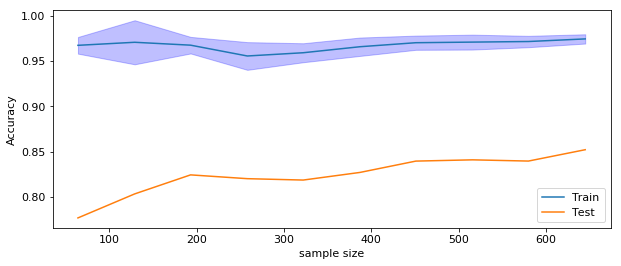

In [24]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve shows too much variance:')


Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the logistic regression model. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [25]:
from sklearn.model_selection import validation_curve

Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [26]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.721060  0.721049
0.264105        0.748798  0.744738
0.527211        0.795132  0.785172
0.790316        0.827832  0.807433
1.053421        0.839763  0.818584


Text(0,0.5,'Accuracy')

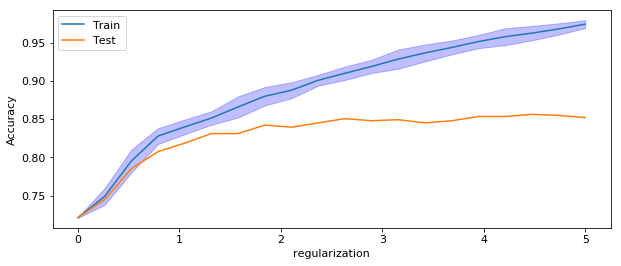

In [27]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We see that the average prediction accuracy (between training and test set) starts decreasing steeply after a `C` value of 1. Lets plot a more detailed validation curve for values lower than 1.

In [28]:
Cs = np.linspace(0.001, 1, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [29]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.721060  0.721049
0.053579        0.721060  0.721049
0.106158        0.721060  0.721049
0.158737        0.721060  0.721049
0.211316        0.730513  0.732199


Text(0,0.5,'Accuracy')

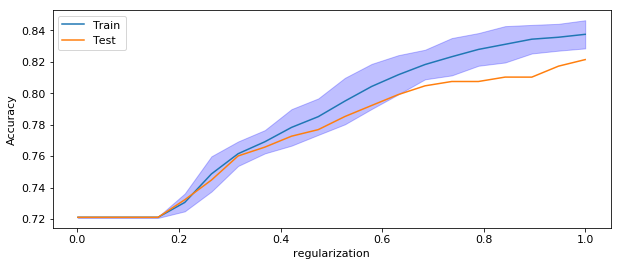

In [30]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We select a regularization `C` = 0.6 setting for which the test accuracy is in the confidence band of the training accuracy to see whether the learning curves improve.

### Make learning curve

In [31]:
logreg_mod = LogisticRegression(penalty = 'l1', C = 0.6, random_state = 1) #moderate regularization

#### Moderate setting:

In [32]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_mod,
                   X=X_dev_vec_b,
                   y=y_dev_b,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [33]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size')) 
print(acc_.head())

                Train      Test
sample size                    
64           0.684375  0.721049
129          0.682946  0.721049
193          0.698964  0.721049
258          0.727519  0.723846
322          0.767702  0.753149


This learning curve looks ok regarding the size of our training data:


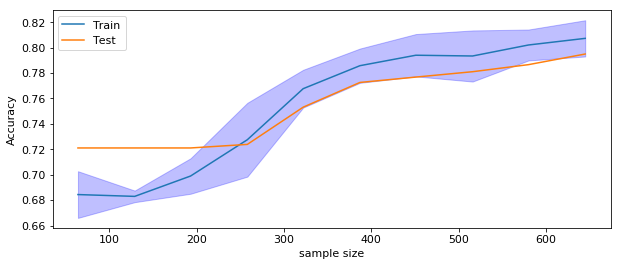

In [34]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve looks ok regarding the size of our training data:')

### Fit final logistic regression classification model to training and test data

We now fit the final model, with `C` = 0.6 to our training and test data.

In [35]:
sentiment_logreg_mod = logreg_mod.fit(X_dev_vec_b, y_dev_b)
print('Training Accuracy: ', A(sentiment_logreg_mod, X_dev_vec_b, y_dev_b))
print('Test Accuracy: ', A(sentiment_logreg_mod, X_test_vec_b, y_test_b))

Training Accuracy:  0.8145048814504882
Test Accuracy:  0.762987012987013


The training is much lower and it is reasonably close to the test accuracy. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [36]:
#Put tokens, coefficients and odds ratios in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_b), pd.DataFrame(sentiment_logreg_mod.coef_.T), pd.DataFrame(np.exp(sentiment_logreg_mod.coef_).T)], axis = 1) 
coef_tokens.columns = ['Token', 'Coef', 'OR']

#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    6220
True       18
Name: Coef, dtype: int64


In [37]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value and exponentiate to get odds ratio
coef_tokens_sorted = coef_tokens.sort_values('Coef')
print(coef_tokens_sorted[['Token', 'Coef', 'OR']]) #sort and print to get highest and lowest coefficients

        Token      Coef          OR
2570     ikke -6.486547    0.001524
1639      for -4.288957    0.013719
5987       vi -2.643444    0.071116
543        at -2.203462    0.110420
5276       så -2.048961    0.128869
22          , -1.788727    0.167173
45        ... -1.472202    0.229420
5894      var -1.346208    0.260225
43          . -1.221690    0.294732
1295   dårlig -0.410322    0.663436
17          )  0.084167    1.087811
2111     gode  0.157473    1.170549
3361      mad  0.261724    1.299168
457     altid  0.587276    1.799081
331         :  0.971494    2.641889
1138  dejligt  1.720380    5.586650
5208    super  2.999448   20.074455
2109      god  6.902871  995.127572


Now lets plot these:

        Token      Coef          OR
2570     ikke -6.486547    0.001524
1639      for -4.288957    0.013719
5987       vi -2.643444    0.071116
543        at -2.203462    0.110420
5276       så -2.048961    0.128869
22          , -1.788727    0.167173
45        ... -1.472202    0.229420
5894      var -1.346208    0.260225
43          . -1.221690    0.294732
1295   dårlig -0.410322    0.663436
17          )  0.084167    1.087811
2111     gode  0.157473    1.170549
3361      mad  0.261724    1.299168
457     altid  0.587276    1.799081
331         :  0.971494    2.641889
1138  dejligt  1.720380    5.586650
5208    super  2.999448   20.074455
2109      god  6.902871  995.127572


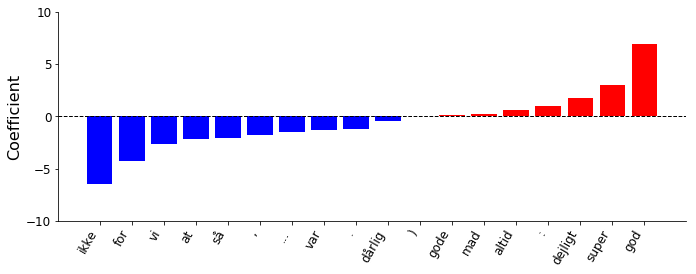

In [38]:
top_features_n = 10
top_features_p = 8
top_features = 18

top_pos_coef = coef_tokens_sorted.iloc[-top_features_p:]
top_neg_coef = coef_tokens_sorted.iloc[:top_features_n]
top = pd.concat([top_pos_coef, top_neg_coef], axis = 0).sort_values('Coef')
print(top)
colors = ['red' if c > 0 else 'blue' for c in top['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top['Coef'], color=colors)
features = np.array(top['Token'])
plt.xticks(np.arange(0, top_features), top['Token'], rotation=60, ha='right')
plt.yticks([-10, -5, 0, 5, 10])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=20, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Coefficient", fontsize=16)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsLogistic_b.png')

<br><br>
## Implement the Naive Bayes Classifier

First we naïvely fit the Naive Bayes classifier to the training data. 

In [39]:
sentiment_NB = NB.fit(X_dev_vec_b.toarray(), y_dev_b) #need to convert to np array, not sparse

print('Training Accuracy: ', A(sentiment_NB, X_dev_vec_b.toarray(), np.array(y_dev_b)))

Training Accuracy:  0.796373779637378


The accuracy value of both the training data is low. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [40]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB,
                   X=X_dev_vec_b.toarray(),
                   y=y_dev_b,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [41]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
64           0.684375  0.721049
129          0.682946  0.721049
193          0.740415  0.729460
258          0.798450  0.739261
322          0.850621  0.771283


There is too much variance and bias according to this learning curve:


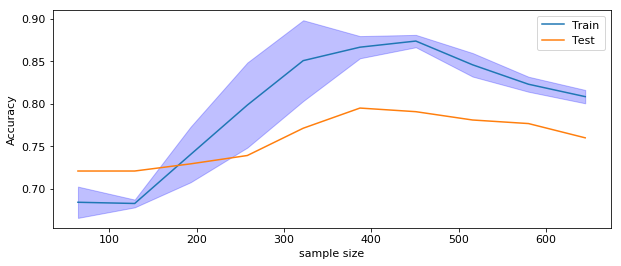

In [42]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('There is too much variance and bias according to this learning curve:')

Because the learning curve too much variance and bias we want to see whether we can optimize the prior of the Naive Bayes classifier. This may be a controversial idea. Ideally, when we fit Bayesian models we need to specify a prior, that reflects our belief about the 'truth', in this case the proportion of negative and positive sentiments, before we fit a model. These prior probabilities could for example be derived from our knowledge of the proportions in the wider population, perhaps gained from  the literature. It would thus be odd to optimize a model based on the prior. We may also consider setting the prior to the proportions from the training set; this is what is done by default in the Naive Bayes classifier from sklearn. According to http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.2085&rep=rep1&type=pdf putting a uniform prior may actually improve performance. 

In [43]:
NB_unif = BernoulliNB(class_prior = [0.5, 0.5])

In [44]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB_unif,
                   X=X_dev_vec_b.toarray(),
                   y=y_dev_b,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [45]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
64           0.684375  0.721049
129          0.682946  0.721049
193          0.751813  0.733627
258          0.809302  0.744875
322          0.856832  0.774061


This looks very much like the curve above:


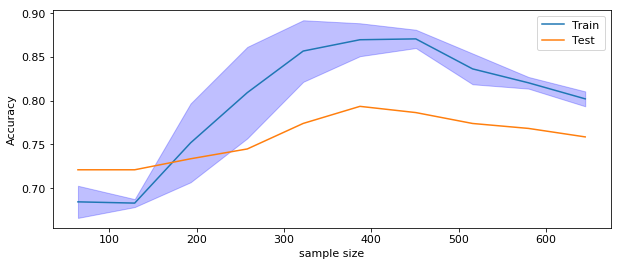

In [46]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This looks very much like the curve above:')

Since adapting the prior does not see to change the learning curve a lot we could try to optimize the smoothing parameter `alpha`. This parameter determines the smooting of the prior and accounts for features not present in the learning samples and prevents zero probabilities in further computations. 

### Make a Validation curve

In [47]:
alphas = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= NB,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     param_name='alpha',
                     param_range=alphas,
                     scoring=A,                 
                     cv=10)

In [48]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(alphas,name='smoothing'))    
print(acc_.head())

              Train      Test
smoothing                    
0.001000   0.890748  0.779538
0.264105   0.788624  0.716843
0.527211   0.788625  0.722437
0.790316   0.793273  0.746088
1.053421   0.812025  0.762813


There seems to be a decrease in bias for lower alpha values, 
the variance however becomes larger:


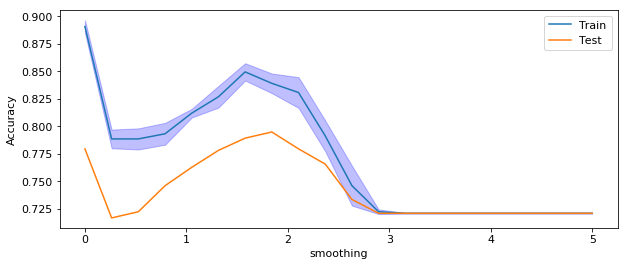

In [49]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(alphas,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')
print('There seems to be a decrease in bias for lower alpha values, \nthe variance however becomes larger:')

The best `alpha` for which the training accuracy is still within the confidence bands of the training accuracy is about 2.5. 

### Fit the final naive Bayes classifier to the training and test data

We now fit the final model to our training and test data

In [50]:
NB_adj_alpha = BernoulliNB(alpha = 2.5)

sentiment_NB_adj = NB_adj_alpha.fit(X_dev_vec_b.toarray(), np.array(y_dev_b)) 

print('Training Accuracy: ', A(sentiment_NB_adj, X_dev_vec_b.toarray(), np.array(y_dev_b)))
print('Test Accuracy: ', A(sentiment_NB_adj, X_test_vec_b.toarray(), np.array(y_test_b)))

Training Accuracy:  0.806136680613668
Test Accuracy:  0.762987012987013


In [51]:
#Put tokens and coefficients in one dataframe
feat_prob = pd.DataFrame(np.exp(sentiment_NB.feature_log_prob_).T)
feat_prob.columns = ['Negative', "Positive"]

#compute the ratio of probability of being predicted as a negative vs positive sentiment divided by the sum of probabilities
feat_prob_ratio_neg = (feat_prob['Negative']/feat_prob['Positive'])*(feat_prob['Negative'])
feat_prob_ratio_pos = (feat_prob['Positive']/feat_prob['Negative'])*(feat_prob['Positive'])

coef_tokens = pd.concat([pd.Series(tokens_b), feat_prob, feat_prob_ratio_neg, feat_prob_ratio_pos], axis = 1) 
coef_tokens.columns = ['Token', 'Negative', "Positive", "RatioNP", 'RatioPN']


#Sort

coef_tokens['highest'] = abs(coef_tokens[["RatioNP", "RatioPN"]]).max(axis=1)
coef_high = coef_tokens.sort_values('highest', ascending = False)
coef_high['color'] = (coef_high['RatioNP'] > coef_high['RatioPN']).replace([False, True], ['red', 'blue'])
coef_high_sorted_neg = coef_tokens.sort_values(['RatioNP'], ascending = False)
coef_high_sorted_pos = coef_tokens.sort_values(['RatioPN'], ascending = False)

#Print
print(coef_high.head(20))


        Token  Negative  Positive   RatioNP   RatioPN   highest color
5427  tilbage  0.121387  0.004950  2.976444  0.000202  2.976444  blue
1100       da  0.452794  0.094059  2.179710  0.019539  2.179710  blue
2570     ikke  0.764933  0.301980  1.937617  0.119216  1.937617  blue
2249    havde  0.385356  0.084158  1.764525  0.018379  1.764525  blue
1323    efter  0.289017  0.049505  1.687327  0.008480  1.687327  blue
1639      for  0.631985  0.237624  1.680827  0.089346  1.680827  blue
1138  dejligt  0.003854  0.079208  0.000187  1.628076  1.628076   red
5276       så  0.585742  0.222772  1.540108  0.084726  1.540108  blue
4675    siden  0.119461  0.009901  1.441352  0.000821  1.441352  blue
5894      var  0.670520  0.326733  1.376040  0.159211  1.376040  blue
543        at  0.764933  0.425743  1.374356  0.236958  1.374356  blue
1152      den  0.514451  0.202970  1.303933  0.080079  1.303933  blue
3474      men  0.601156  0.287129  1.258629  0.137141  1.258629  blue
1158      der  0.680

Lets plot these:

5427    tilbage
1100         da
2570       ikke
2249      havde
1323      efter
1639        for
5276         så
4675      siden
5894        var
543          at
1152        den
3474        men
1158        der
1189        det
2532          i
1384         en
22            ,
2069        gik
3530        min
1138    dejligt
Name: Token, dtype: object


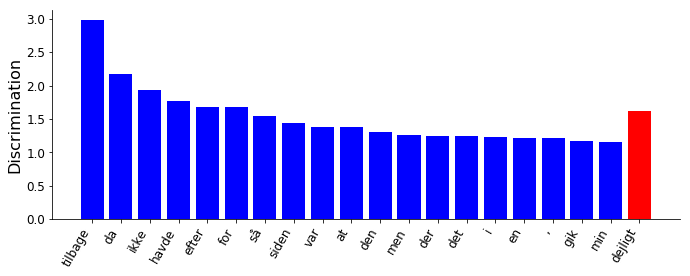

In [52]:
top_features = 20

top = coef_high.iloc[:top_features].sort_values(['RatioNP','highest'], ascending = False)
colors = top['color']

barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top.highest, color = colors)
features = top.Token
plt.xticks(np.arange(0, top_features), features, rotation=60, ha='right')

ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Discrimination", fontsize=16)

print(features)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsEB_b.png')

<br><br>
## Implement a support vector classifier

First we naïvely fit the support vector classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [53]:
#First we naïvely fit the model:
sentiment_svc_lib = svc_lib.fit(X_dev_vec_b, y_dev_b) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_svc_lib, X_dev_vec_b, np.array(y_dev_b))) 

Training Accuracy:  1.0


The accuracy value of the training data is very high and there might be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [54]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_lib,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [55]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

             Train      Test
sample size                 
64             1.0  0.772613
129            1.0  0.801858
193            1.0  0.817254
258            1.0  0.811659
322            1.0  0.814495


This learning has too much variance


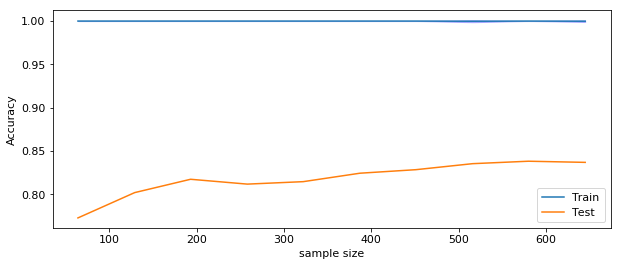

In [56]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning has too much variance')

Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the support vector classifier. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [57]:
Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [58]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.721060  0.721049
0.264105        0.834649  0.821381
0.527211        0.887183  0.846401
0.790316        0.925463  0.849257
1.053421        0.952115  0.853423


Text(0,0.5,'Accuracy')

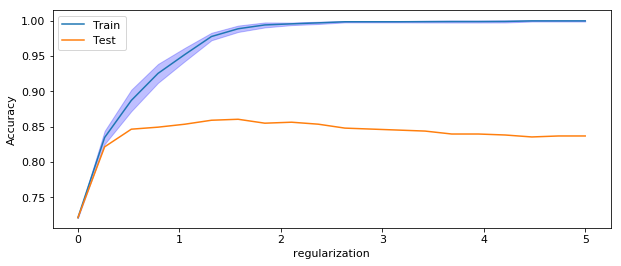

In [59]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We see that the average prediction accuracy (between training and test set) starts decreasing steeply after a `C` value of 1. Lets plot a more detailed validation curve for values lower than 1.

In [60]:
Cs = np.linspace(0.001, 1, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [61]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.721060  0.721049
0.053579        0.730358  0.732199
0.106158        0.774212  0.771264
0.158737        0.807374  0.790747
0.211316        0.828605  0.808842


Text(0,0.5,'Accuracy')

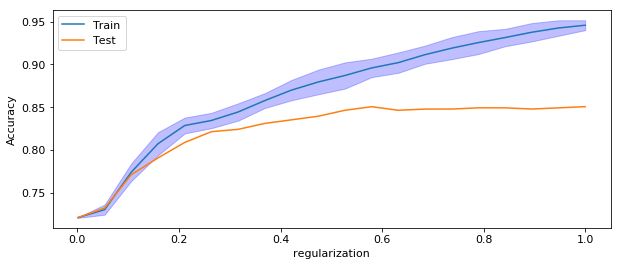

In [62]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We select a regularization setting `C` = 0.15 for which the test accuracy is still within the confidence bands of the training accuracy to see whether the learning curves improve.

### Make learning curve

In [63]:
svc_mod = LinearSVC(penalty = 'l1', C = 0.15, random_state = 1, dual = False) #moderate regularization

In [64]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_mod,
                     X=X_dev_vec_b,
                     y=y_dev_b,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [65]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
64           0.684375  0.721049
129          0.682946  0.721049
193          0.698964  0.721049
258          0.725969  0.723846
322          0.765217  0.750333


Seems ok for our sample size


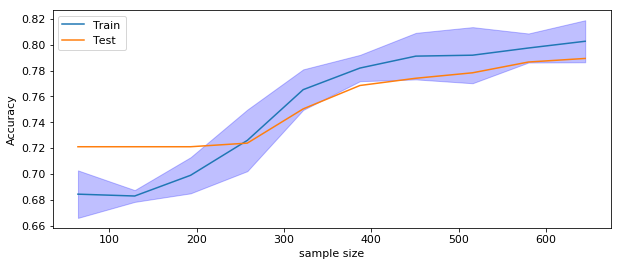

In [66]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('Seems ok for our sample size')

### Fit final support vector classification model to training and test data

We now fit the final model, with `C` = 0.15 to our training and test data.

In [67]:
sentiment_svc_mod = svc_mod.fit(X_dev_vec_b, y_dev_b)
print('Training Accuracy: ', A(sentiment_svc_mod, X_dev_vec_b, y_dev_b))
print('Test Accuracy: ', A(sentiment_svc_mod, X_test_vec_b, y_test_b))

Training Accuracy:  0.8117154811715481
Test Accuracy:  0.7662337662337663


The training and test accuracy are now much lower and closer together. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [68]:
#Put tokens and coefficients in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_b), pd.DataFrame(sentiment_svc_mod.coef_.T)], axis = 1) 
coef_tokens.columns = ['Token', 'Coef']

#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    6220
True       18
Name: Coef, dtype: int64


In [69]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value
coef_tokens_sorted = coef_tokens.sort_values('Coef')#sort and print to get highest and lowest coefficients
print(coef_tokens_sorted[['Token', 'Coef']]) 


        Token      Coef
2570     ikke -2.291800
1639      for -1.578255
5987       vi -0.817289
5276       så -0.728242
543        at -0.703930
22          , -0.646147
45        ... -0.577277
5894      var -0.545482
43          . -0.511829
1295   dårlig -0.151297
17          )  0.025401
2111     gode  0.083850
3361      mad  0.168967
457     altid  0.292638
331         :  0.526436
1138  dejligt  0.737698
5208    super  1.301018
2109      god  2.772854


Lets plot these:

        Token      Coef
2570     ikke -2.291800
1639      for -1.578255
5987       vi -0.817289
5276       så -0.728242
543        at -0.703930
22          , -0.646147
45        ... -0.577277
5894      var -0.545482
43          . -0.511829
1295   dårlig -0.151297
17          )  0.025401
2111     gode  0.083850
3361      mad  0.168967
457     altid  0.292638
331         :  0.526436
1138  dejligt  0.737698
5208    super  1.301018
2109      god  2.772854


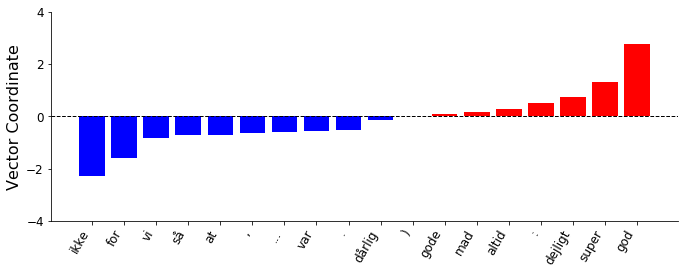

In [70]:
top_features_n = 10
top_features_p = 8
top_features = 18

top_pos_coef = coef_tokens_sorted.iloc[-top_features_p:]
top_neg_coef = coef_tokens_sorted.iloc[:top_features_n]
top = pd.concat([top_pos_coef, top_neg_coef], axis = 0).sort_values('Coef')
print(top)
colors = ['red' if c > 0 else 'blue' for c in top['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top['Coef'], color=colors)
features = np.array(top['Token'])
plt.xticks(np.arange(0, top_features), top['Token'], rotation=60, ha='right')
plt.yticks([ -4, -2, 0, 2, 4])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=20, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Vector Coordinate", fontsize=16)

plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsSVC_b.png')

<br><br>
# Classification during September 2014

<br><br>
## Implement the logistic regression classifier

First we naïvely fit the logistic regression classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [71]:
#First we naïvely fit the model:
sentiment_logreg_lib = logreg_lib.fit(X_dev_vec_d, y_dev_d) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_logreg_lib, X_dev_vec_d, np.array(y_dev_d))) 

Training Accuracy:  0.9868020304568528


The accuracy value of the training data is very high and there might be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [72]:
from sklearn.model_selection import learning_curve

train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_lib,
                   X=X_dev_vec_d,
                   y=y_dev_d,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [73]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
88           0.965909  0.923880
177          0.977966  0.930961
265          0.980755  0.937053
354          0.983051  0.946175
443          0.987133  0.942082


This learning curve shows too much variance:


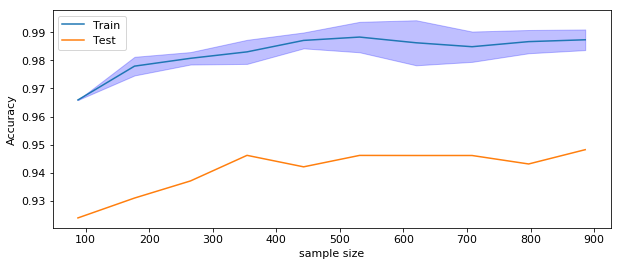

In [74]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve shows too much variance:')


Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the logistic regression model. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [75]:
from sklearn.model_selection import validation_curve

Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [76]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.912691  0.912717
0.264105        0.917202  0.917788
0.527211        0.925099  0.921860
0.790316        0.932769  0.927931
1.053421        0.940214  0.933012


Text(0,0.5,'Accuracy')

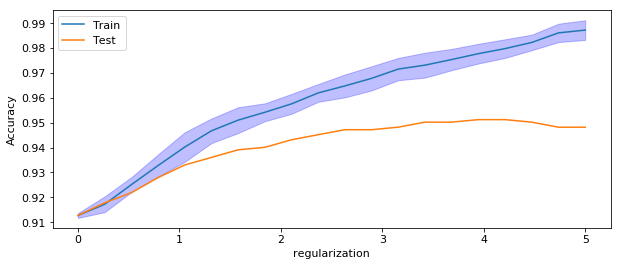

In [77]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

Lets plot a more detailed validation curve for values lower than 2.

In [78]:
Cs = np.linspace(0.001, 2, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [79]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.912691  0.912717
0.106211        0.912691  0.912717
0.211421        0.913480  0.912717
0.316632        0.919571  0.919819
0.421842        0.922505  0.919819


Text(0,0.5,'Accuracy')

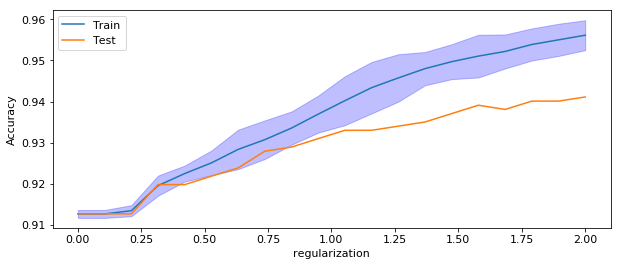

In [80]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

Even with a regularization parameter very close to 0 we get a very high accuracy!! We select a regularization setting `C` = 0.8 for which the test accuracy is still within the training accuray confidence bands to see whether the learning curves improve.

### Make learning curve

In [81]:
logreg_mod = LogisticRegression(penalty = 'l1', C = 0.8, random_state = 1) 

In [82]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_mod,
                   X=X_dev_vec_d,
                   y=y_dev_d,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [83]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size')) 
print(acc_.head())

                Train      Test
sample size                    
88           0.917045  0.912717
177          0.900565  0.916768
265          0.913962  0.918799
354          0.903390  0.922880
443          0.911287  0.925931


This learning curve also looks ok for our sample size: 


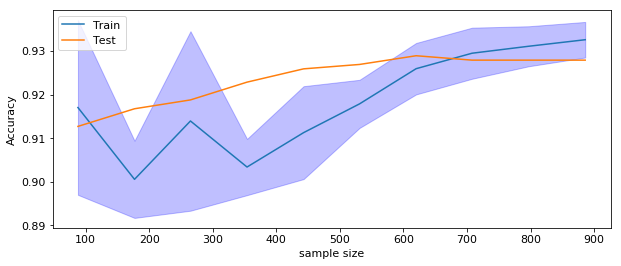

In [84]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve also looks ok for our sample size: ')

### Fit final logistic regression classification model to training and test data

We now fit the final model, with `C` = 0.8 to our training and test data.

In [85]:
sentiment_logreg_mod = logreg_mod.fit(X_dev_vec_d, y_dev_d)
print('Training Accuracy: ', A(sentiment_logreg_mod, X_dev_vec_d, y_dev_d))
print('Test Accuracy: ', A(sentiment_logreg_mod, X_test_vec_d, y_test_d))

Training Accuracy:  0.934010152284264
Test Accuracy:  0.9314420803782506


The training is lower and it is reasonably close to the test accuracy. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [86]:
#Put tokens, coefficients and odds ratios in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_d), pd.DataFrame(sentiment_logreg_mod.coef_.T), pd.DataFrame(np.exp(sentiment_logreg_mod.coef_).T)], axis = 1) 
coef_tokens.columns = ['Token', 'Coef', 'OR']

#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    5047
True       12
Name: Coef, dtype: int64


In [87]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value and exponentiate to get odds ratio
coef_tokens_sorted = coef_tokens.sort_values('Coef')
print(coef_tokens_sorted[['Token', 'Coef', 'OR']]) #sort and print to get highest and lowest coefficients

       Token       Coef             OR
954   dårlig  -3.664693       0.025612
1984    ikke  -2.191006       0.111804
809   dejlig   0.693875       2.001455
4203   super   1.055207       2.872570
4088    sted   1.336456       3.805532
1025  elsker   1.861101       6.430812
174        :   1.945236       6.995285
1615    godt   3.461293      31.858136
1614    gode   3.499517      33.099476
281    altid   4.218170      67.909101
1173    fint   4.754993     116.162875
1612     god  12.268748  212936.252181


Now lets plot these:

       Token       Coef             OR
954   dårlig  -3.664693       0.025612
1984    ikke  -2.191006       0.111804
809   dejlig   0.693875       2.001455
4203   super   1.055207       2.872570
4088    sted   1.336456       3.805532
1025  elsker   1.861101       6.430812
174        :   1.945236       6.995285
1615    godt   3.461293      31.858136
1614    gode   3.499517      33.099476
281    altid   4.218170      67.909101
1173    fint   4.754993     116.162875
1612     god  12.268748  212936.252181


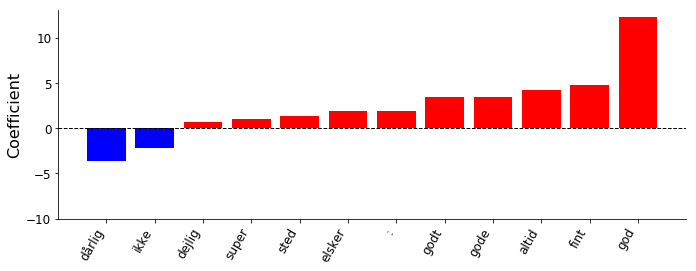

In [88]:
top_features_n = 2
top_features_p = 10

top_features = 12

top_pos_coef = coef_tokens_sorted.iloc[-top_features_p:]
top_neg_coef = coef_tokens_sorted.iloc[:top_features_n]
top = pd.concat([top_pos_coef, top_neg_coef], axis = 0).sort_values('Coef')
print(top)
colors = ['red' if c > 0 else 'blue' for c in top['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top['Coef'], color=colors)
features = np.array(top['Token'])
plt.xticks(np.arange(0, top_features), top['Token'], rotation=60, ha='right')
plt.yticks([-10, -5, 0, 5, 10])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=20, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Coefficient", fontsize=16)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsLogistic_d.png')

<br><br>
## Implement the Naive Bayes Classifier

First we naïvely fit the Naive Bayes classifier to the training data. 

In [89]:
sentiment_NB = NB.fit(X_dev_vec_d.toarray(), y_dev_d) #need to convert to np array, not sparse

print('Training Accuracy: ', A(sentiment_NB, X_dev_vec_d.toarray(), np.array(y_dev_d)))

Training Accuracy:  0.9126903553299492


The accuracy value of the training data is quite high. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [90]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB,
                   X=X_dev_vec_d.toarray(),
                   y=y_dev_d,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [91]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
88           0.917045  0.912717
177          0.899435  0.912717
265          0.900000  0.909666
354          0.892938  0.906636
443          0.900677  0.902585


This learning curve looks ok:


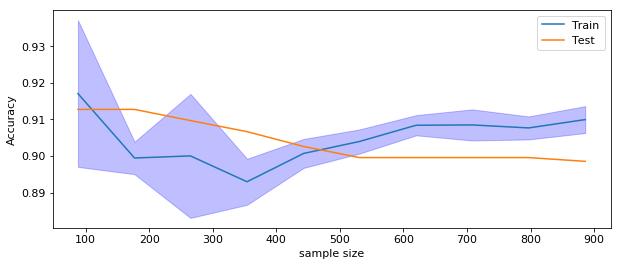

In [92]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve looks ok:')

Even though the learning curve does not show a lot of variance we want to see whether we can optimize the prior of the Naive Bayes classifier. This may be a controversial idea. Ideally, when we fit Bayesian models we need to specify a prior, that reflects our belief about the 'truth', in this case the proportion of negative and positive sentiments, before we fit a model. These prior probabilities could for example be derived from our knowledge of the proportions in the wider population, perhaps gained from  the literature. It would thus be odd to optimize a model based on the prior. We may also consider setting the prior to the proportions from the training set; this is what is done by default in the Naive Bayes classifier from sklearn. According to http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.2085&rep=rep1&type=pdf putting a uniform prior may actually improve performance. 

In [93]:
NB_unif = BernoulliNB(class_prior = [0.5, 0.5])

In [94]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB_unif,
                   X=X_dev_vec_d.toarray(),
                   y=y_dev_d,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [95]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
88           0.917045  0.912717
177          0.899435  0.912717
265          0.900000  0.909666
354          0.892938  0.906636
443          0.900677  0.901575


This looks very much like the curve above:


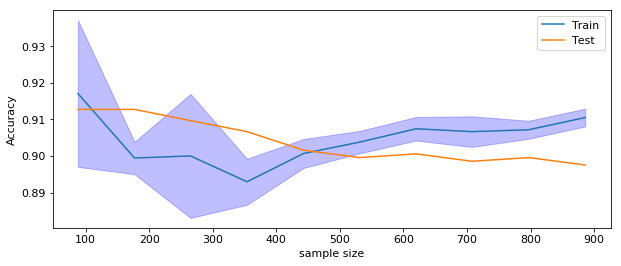

In [96]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This looks very much like the curve above:')

Since adapting the prior does not see to change the learning curve a lot we could try to optimize the smoothing parameter `alpha`. This parameter determines the smooting of the prior and accounts for features not present in the learning samples and prevents zero probabilities in further computations. 

### Make a Validation curve

In [97]:
alphas = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= NB,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     param_name='alpha',
                     param_range=alphas,
                     scoring=A,                 
                     cv=10)

In [98]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(alphas,name='smoothing'))    
print(acc_.head())

              Train      Test
smoothing                    
0.001000   0.935591  0.853842
0.264105   0.985334  0.904533
0.527211   0.935364  0.887299
0.790316   0.914721  0.894463
1.053421   0.908855  0.898535


There is a decrease in variance for higher alpha values:


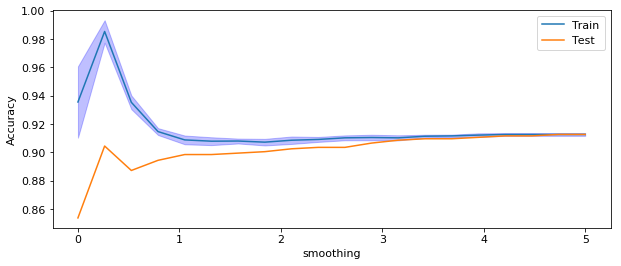

In [99]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(alphas,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')
print('There is a decrease in variance for higher alpha values:')

Setting the `alpha` parameter to 3 seems to be optimal. 

### Fit the final naive Bayes classifier to the training and test data

We now fit the final model to our training and test data

In [100]:
NB_adj_alpha = BernoulliNB(alpha = 3)

sentiment_NB_adj = NB_adj_alpha.fit(X_dev_vec_d.toarray(), np.array(y_dev_d)) 
#note that it set the alpha to 1.0e-10 to prevent numeric errors

print('Training Accuracy: ', A(sentiment_NB_adj, X_dev_vec_d.toarray(), np.array(y_dev_d)))
print('Test Accuracy: ', A(sentiment_NB_adj, X_test_vec_d.toarray(), np.array(y_test_d)))

Training Accuracy:  0.9106598984771573
Test Accuracy:  0.9196217494089834


In [101]:
#Put tokens and coefficients in one dataframe
feat_prob = pd.DataFrame(np.exp(sentiment_NB.feature_log_prob_).T)
feat_prob.columns = ['Negative', "Positive"]

#compute the ratio of probability of being predicted as a negative vs positive sentiment divided by the sum of probabilities
feat_prob_ratio_neg = (feat_prob['Negative']/feat_prob['Positive'])*(feat_prob['Negative'])
feat_prob_ratio_pos = (feat_prob['Positive']/feat_prob['Negative'])*(feat_prob['Positive'])

coef_tokens = pd.concat([pd.Series(tokens_d), feat_prob, feat_prob_ratio_neg, feat_prob_ratio_pos], axis = 1) 
coef_tokens.columns = ['Token', 'Negative', "Positive", "RatioNP", 'RatioPN']


#Sort

coef_tokens['highest'] = abs(coef_tokens[["RatioNP", "RatioPN"]]).max(axis=1)
coef_high = coef_tokens.sort_values('highest', ascending = False)
coef_high['color'] = (coef_high['RatioNP'] > coef_high['RatioPN']).replace([False, True], ['red', 'blue'])
coef_high_sorted_neg = coef_tokens.sort_values(['RatioNP'], ascending = False)
coef_high_sorted_pos = coef_tokens.sort_values(['RatioPN'], ascending = False)

#Print
print(coef_high.head(20))


              Token  Negative  Positive   RatioNP   RatioPN   highest color
1612            god  0.062153  0.443182  0.008717  3.160099  3.160099   red
810         dejligt  0.001110  0.056818  0.000022  2.908704  2.908704   red
1025         elsker  0.002220  0.068182  0.000072  2.094267  2.094267   red
2595         lækker  0.005549  0.102273  0.000301  1.884840  1.884840   red
1398    fremragende  0.001110  0.045455  0.000027  1.861570  1.861570   red
4832        venligt  0.001110  0.045455  0.000027  1.861570  1.861570   red
4203          super  0.011099  0.136364  0.000903  1.675413  1.675413   red
809          dejlig  0.005549  0.090909  0.000339  1.489256  1.489256   red
281           altid  0.045505  0.250000  0.008283  1.373476  1.373476   red
1165            fin  0.007769  0.102273  0.000590  1.346314  1.346314   red
1173           fint  0.009989  0.113636  0.000878  1.292757  1.292757   red
954          dårlig  0.241953  0.045455  1.287912  0.008539  1.287912  blue
3942       s

Lets plot these:

954            dårlig
720     børnefamilier
2621          lørdags
1171           finger
4338           thumps
3230       personligt
645               bud
4716               up
3942         smilende
1173             fint
1165              fin
281             altid
809            dejlig
4203            super
1398      fremragende
4832          venligt
2595           lækker
1025           elsker
810           dejligt
1612              god
Name: Token, dtype: object


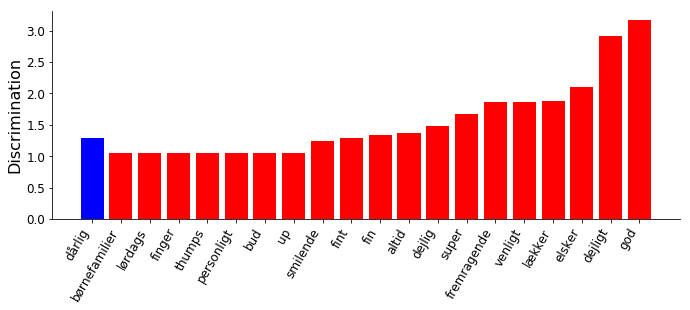

In [102]:
top_features = 20

top = coef_high.iloc[:top_features].sort_values(['color','highest'], ascending = True)
colors = top['color']

barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top.highest, color = colors)
features = top.Token
plt.xticks(np.arange(0, top_features), features, rotation=60, ha='right')

ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Discrimination", fontsize=16)

print(features)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)

plt.savefig('CoefficientsEB_d.png')

<br><br>
## Implement a support vector classifier

First we naïvely fit the support vector classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [103]:
#First we naïvely fit the model:
sentiment_svc_lib = svc_lib.fit(X_dev_vec_d, y_dev_d) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_svc_lib, X_dev_vec_d, np.array(y_dev_d))) 

Training Accuracy:  1.0


The accuracy value of the training data is very high and there might be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [104]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_lib,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [105]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

             Train      Test
sample size                 
88             1.0  0.929951
177            1.0  0.929920
265            1.0  0.938032
354            1.0  0.943134
443            1.0  0.938032


This learning curve has too much variance


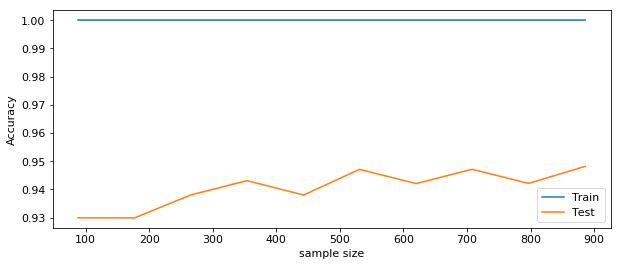

In [106]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve has too much variance')

Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the support vector classifier. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [107]:
Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [108]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.912691  0.912717
0.264105        0.935250  0.929961
0.527211        0.953073  0.941114
0.790316        0.966836  0.944144
1.053421        0.977665  0.947216


Text(0,0.5,'Accuracy')

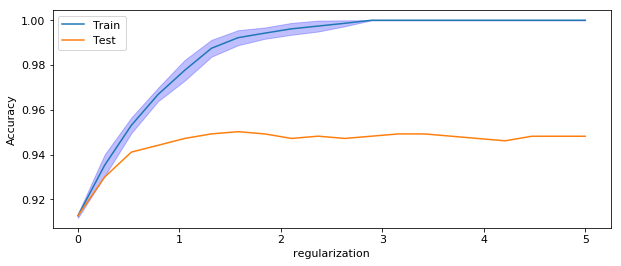

In [109]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We see that the average prediction accuracy (between training and test set) starts decreasing steeply after a `C` value of 1.5. Lets plot a more detailed validation curve for values lower than 1.5.

In [110]:
Cs = np.linspace(0.001, 1.5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [111]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.912691  0.912717
0.079895        0.918556  0.918799
0.158789        0.925099  0.921860
0.237684        0.932318  0.928951
0.316579        0.939763  0.930972


Text(0,0.5,'Accuracy')

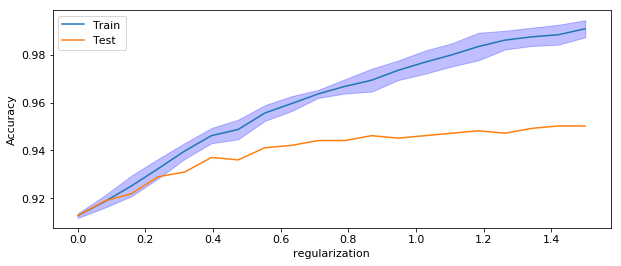

In [112]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

### Make learning curve

In [113]:
svc_mod = LinearSVC(penalty = 'l1', C = 0.25, random_state = 1, dual = False) #moderate regularization

In [114]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_mod,
                     X=X_dev_vec_d,
                     y=y_dev_d,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [115]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
88           0.917045  0.912717
177          0.911299  0.917788
265          0.910943  0.921860
354          0.905367  0.924921
443          0.913544  0.927962


Seems ok for our sample size


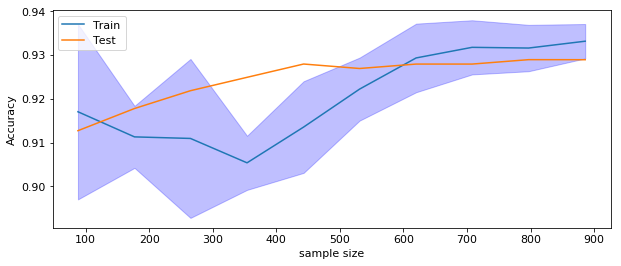

In [116]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('Seems ok for our sample size')

### Fit final support vector classification model to training and test data

We now fit the final model, with `C` = 0.25 to our training and test data.

In [117]:
sentiment_svc_mod = svc_mod.fit(X_dev_vec_d, y_dev_d)
print('Training Accuracy: ', A(sentiment_svc_mod, X_dev_vec_d, y_dev_d))
print('Test Accuracy: ', A(sentiment_svc_mod, X_test_vec_d, y_test_d))

Training Accuracy:  0.9360406091370559
Test Accuracy:  0.9385342789598109


The training and test accuracy are now much lower and closer together. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [118]:
#Put tokens and coefficients in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_d),
                         pd.DataFrame(sentiment_svc_mod.coef_.T),
                         abs(pd.DataFrame(sentiment_svc_mod.coef_.T))], axis = 1) 
coef_tokens.columns = ['Token', 'Coef', 'absCoef']




#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    5037
True       22
Name: Coef, dtype: int64


In [119]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value
coef_tokens_sorted = coef_tokens.sort_values('absCoef', ascending = False)#sort and print to get highest and lowest coefficients
print(coef_tokens_sorted[['Token', 'Coef', 'absCoef']]) 


        Token      Coef   absCoef
1612      god  3.624407  3.624407
1173     fint  1.953142  1.953142
281     altid  1.202280  1.202280
1614     gode  1.179384  1.179384
1025   elsker  1.083568  1.083568
1615     godt  0.863293  0.863293
1165      fin  0.708215  0.708215
4203    super  0.649293  0.649293
809    dejlig  0.557209  0.557209
2595   lækker  0.507568  0.507568
174         :  0.505340  0.505340
1984     ikke -0.485001  0.485001
954    dårlig -0.474639  0.474639
4088     sted  0.415871  0.415871
3310   prisen  0.238917  0.238917
22          )  0.232070  0.232070
2093  jensens  0.149414  0.149414
44          . -0.113186  0.113186
3484   rigtig  0.041950  0.041950
4245       så -0.027084  0.027084
347        at -0.023126  0.023126
46        ... -0.000279  0.000279


Lets plot these:

        Token      Coef   absCoef
1612      god  3.624407  3.624407
1173     fint  1.953142  1.953142
281     altid  1.202280  1.202280
1614     gode  1.179384  1.179384
1025   elsker  1.083568  1.083568
1615     godt  0.863293  0.863293
1165      fin  0.708215  0.708215
4203    super  0.649293  0.649293
809    dejlig  0.557209  0.557209
2595   lækker  0.507568  0.507568
174         :  0.505340  0.505340
1984     ikke -0.485001  0.485001
954    dårlig -0.474639  0.474639
4088     sted  0.415871  0.415871
3310   prisen  0.238917  0.238917
22          )  0.232070  0.232070
2093  jensens  0.149414  0.149414
44          . -0.113186  0.113186
3484   rigtig  0.041950  0.041950
4245       så -0.027084  0.027084
        Token      Coef   absCoef
1984     ikke -0.485001  0.485001
954    dårlig -0.474639  0.474639
44          . -0.113186  0.113186
4245       så -0.027084  0.027084
3484   rigtig  0.041950  0.041950
2093  jensens  0.149414  0.149414
22          )  0.232070  0.232070
3310   prisen 

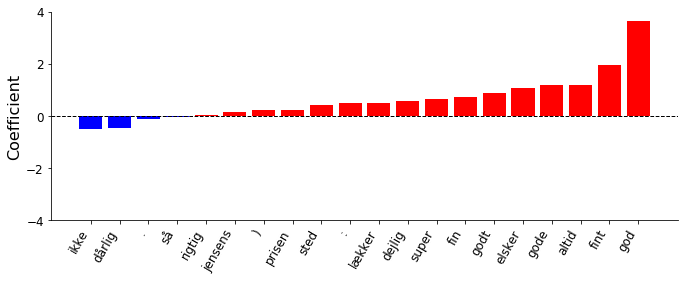

In [120]:
top_features = 10

top = coef_tokens_sorted.iloc[:20]
print(top)
top_sorted = top.sort_values('Coef')
print(top_sorted)
colors = ['red' if c > 0 else 'blue' for c in top_sorted['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(2 * top_features), top_sorted['Coef'], color=colors)
features = np.array(top_sorted['Token'])
plt.xticks(np.arange(0, 2 * top_features), top_sorted['Token'], rotation=60, ha='right')
plt.yticks([-4, -2, 0, 2, 4])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=11, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Coefficient", fontsize=16)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)

plt.savefig('CoefficientsSVC_d.png')

<br><br><br><br>
# Classification after September 2014

<br><br>
## Implement the logistic regression classifier

First we naïvely fit the logistic regression classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [121]:
#First we naïvely fit the model:
sentiment_logreg_lib = logreg_lib.fit(X_dev_vec_a, y_dev_a) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_logreg_lib, X_dev_vec_a, np.array(y_dev_a))) 

Training Accuracy:  0.9722222222222222


The accuracy value of the training data is very high and there might be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [122]:
from sklearn.model_selection import learning_curve

train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_lib,
                   X=X_dev_vec_a,
                   y=y_dev_a,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [123]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
93           0.953763  0.793211
187          0.951872  0.816965
281          0.962989  0.840977
375          0.972000  0.838175
469          0.970362  0.856399


This learning curve shows too much variance:


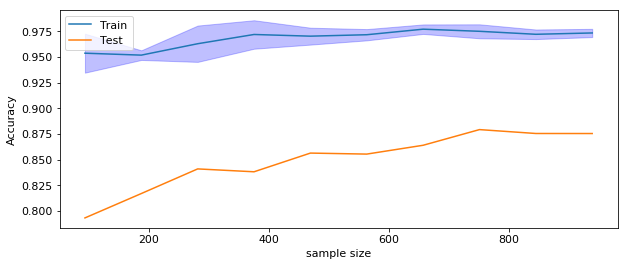

In [124]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve shows too much variance:')


Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the logistic regression model. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [125]:
from sklearn.model_selection import validation_curve

Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [126]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.435824  0.435814
0.264105        0.835034  0.824732
0.527211        0.852809  0.848725
0.790316        0.862708  0.843945
1.053421        0.873670  0.848725


Text(0,0.5,'Accuracy')

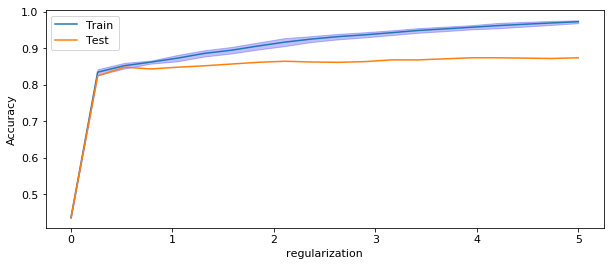

In [127]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We see that the average prediction accuracy (between training and test set) starts decreasing steeply after a `C` value of 1. Lets plot a more detailed validation curve for values lower than 1.

In [128]:
Cs = np.linspace(0.001, 1, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= logreg_lib,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [129]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.435824  0.435814
0.053579        0.564176  0.564186
0.106158        0.766920  0.755802
0.158737        0.805980  0.795051
0.211316        0.818433  0.814182


Text(0,0.5,'Accuracy')

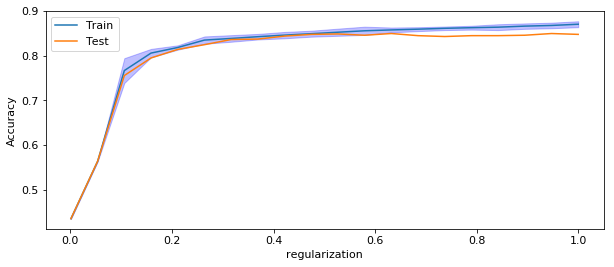

In [130]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We select a regularization setting for which the test accuracy `C` = 0.6 is still within the confidence bands of the training accuracy to see whether the learning curves improve.

### Make learning curve

In [131]:
logreg_mod = LogisticRegression(penalty = 'l1', C = 0.6, random_state = 1) #moderate regularization

In [132]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= logreg_mod,
                   X=X_dev_vec_a,
                   y=y_dev_a,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [133]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size')) 
print(acc_.head())

                Train      Test
sample size                    
93           0.559140  0.570853
187          0.763636  0.758779
281          0.826335  0.796984
375          0.832267  0.811454
469          0.839019  0.833413


This learning curve looks ok regarding the size of our training data (+/- 1000):


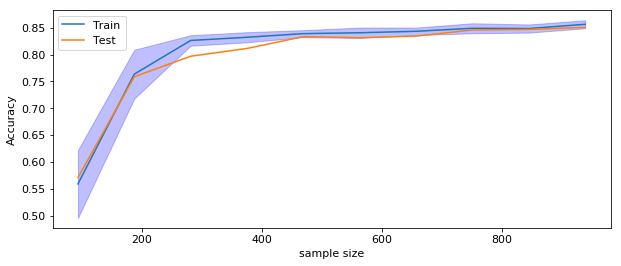

In [134]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning curve looks ok regarding the size of our training data (+/- 1000):')

### Fit final logistic regression classification model to training and test data

We now fit the final model, with `C` = 0.6 to our training and test data.

In [135]:
sentiment_logreg_mod = logreg_mod.fit(X_dev_vec_a, y_dev_a)
print('Training Accuracy: ', A(sentiment_logreg_mod, X_dev_vec_a, y_dev_a))
print('Test Accuracy: ', A(sentiment_logreg_mod, X_test_vec_a, y_test_a))

Training Accuracy:  0.8620689655172413
Test Accuracy:  0.8080357142857143


The training is much lower and it is reasonably close to the test accuracy. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [136]:
#Put tokens, coefficients and odds ratios in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_a),
                         pd.DataFrame(sentiment_logreg_mod.coef_.T),
                         abs(pd.DataFrame(sentiment_logreg_mod.coef_.T)),
                         pd.DataFrame(np.exp(sentiment_logreg_mod.coef_).T)], axis = 1) 
coef_tokens.columns = ['Token', 'Coef', 'absCoef', 'OR']

#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    6915
True       26
Name: Coef, dtype: int64


In [137]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value and exponentiate to get odds ratio
coef_tokens_sorted = coef_tokens.sort_values('absCoef', ascending = False)
print(coef_tokens_sorted[['Token', 'Coef','absCoef', 'OR']]) #sort and print to get highest and lowest coefficients

          Token       Coef    absCoef            OR
2811       ikke -11.263059  11.263059      0.000013
2319        god  11.205658  11.205658  73545.382873
1492     dårlig  -8.099416   8.099416      0.000304
5772      super   4.547746   4.547746     94.419334
658          at  -4.234266   4.234266      0.014490
548       altid   3.707502   3.707502     40.751884
916   betjening   3.418670   3.418670     30.528773
1327     dejlig   2.696092   2.696092     14.821699
2958        jeg  -2.202690   2.202690      0.110505
1290         da  -1.510306   1.510306      0.220842
4206         om  -1.411486   1.411486      0.243781
36            .  -1.332757   1.332757      0.263749
0             !  -1.124163   1.124163      0.324924
1381        det  -1.112344   1.112344      0.328787
3619     lækker   0.963907   0.963907      2.621920
21            ,  -0.963631   0.963631      0.381505
2327       godt   0.923336   0.923336      2.517676
6514        var  -0.856746   0.856746      0.424541
38          

Now lets plot these:

          Token       Coef    absCoef            OR
2811       ikke -11.263059  11.263059      0.000013
2319        god  11.205658  11.205658  73545.382873
1492     dårlig  -8.099416   8.099416      0.000304
5772      super   4.547746   4.547746     94.419334
658          at  -4.234266   4.234266      0.014490
548       altid   3.707502   3.707502     40.751884
916   betjening   3.418670   3.418670     30.528773
1327     dejlig   2.696092   2.696092     14.821699
2958        jeg  -2.202690   2.202690      0.110505
1290         da  -1.510306   1.510306      0.220842
4206         om  -1.411486   1.411486      0.243781
36            .  -1.332757   1.332757      0.263749
0             !  -1.124163   1.124163      0.324924
1381        det  -1.112344   1.112344      0.328787
3619     lækker   0.963907   0.963907      2.621920
21            ,  -0.963631   0.963631      0.381505
2327       godt   0.923336   0.923336      2.517676
6514        var  -0.856746   0.856746      0.424541
38          

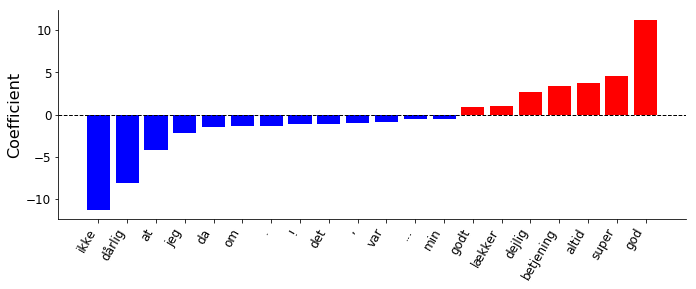

In [138]:
top_features = 10

top = coef_tokens_sorted.iloc[:20]
print(top)
top_sorted = top.sort_values('Coef')
print(top_sorted)
colors = ['red' if c > 0 else 'blue' for c in top_sorted['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(2 * top_features), top_sorted['Coef'], color=colors)
features = np.array(top_sorted['Token'])
plt.xticks(np.arange(0, 2 * top_features), top_sorted['Token'], rotation=60, ha='right')
plt.yticks([-10, -5, 0, 5, 10])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=11, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Coefficient", fontsize=16)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsLogistic_a.png')

<br><br>
## Implement the Naive Bayes Classifier

First we naïvely fit the Naive Bayes classifier to the training data. 

In [139]:
sentiment_NB = NB.fit(X_dev_vec_a.toarray(), y_dev_a) #need to convert to np array, not sparse

print('Training Accuracy: ', A(sentiment_NB, X_dev_vec_a.toarray(), np.array(y_dev_a)))

Training Accuracy:  0.8218390804597702


The accuracy value of the training data is low. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [140]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB,
                   X=X_dev_vec_a.toarray(),
                   y=y_dev_a,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [141]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
93           0.777419  0.692614
187          0.795187  0.752927
281          0.807117  0.771133
375          0.804267  0.774998
469          0.804904  0.775025


There is too much bias and variance according to this learning curve:


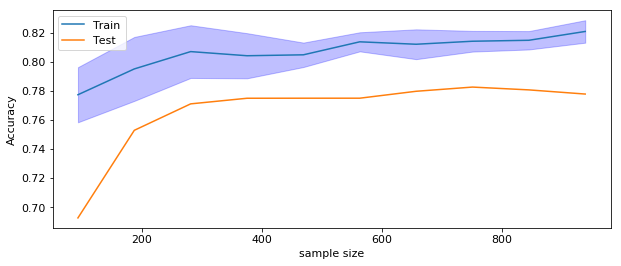

In [142]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('There is too much bias and variance according to this learning curve:')

Because the learning curve shows a lot of bias we want to see whether we can optimize the prior of the Naive Bayes classifier. This may be a controversial idea. Ideally, when we fit Bayesian models we need to specify a prior, that reflects our belief about the 'truth', in this case the proportion of negative and positive sentiments, before we fit a model. These prior probabilities could for example be derived from our knowledge of the proportions in the wider population, perhaps gained from  the literature. It would thus be odd to optimize a model based on the prior. We may also consider setting the prior to the proportions from the training set; this is what is done by default in the Naive Bayes classifier from sklearn. According to http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.2085&rep=rep1&type=pdf putting a uniform prior may actually improve performance. 

In [143]:
NB_unif = BernoulliNB(class_prior = [0.5, 0.5])

In [144]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= NB_unif,
                   X=X_dev_vec_a.toarray(),
                   y=y_dev_a,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring=A,                 
                   cv=10)

In [145]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
93           0.777419  0.692614
187          0.795187  0.752927
281          0.807829  0.771133
375          0.805333  0.775969
469          0.805330  0.775025


This looks very much like the curve above:


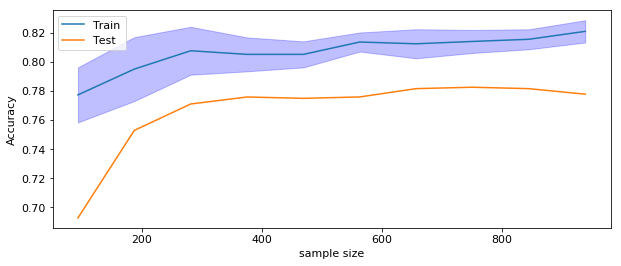

In [146]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This looks very much like the curve above:')

Since adapting the prior does not see to change the learning curve a lot we could try to optimize the smoothing parameter `alpha`. This parameter determines the smooting of the prior and accounts for features not present in the learning samples and prevents zero probabilities in further computations. 

### Make a Validation curve

In [147]:
alphas = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= NB,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     param_name='alpha',
                     param_range=alphas,
                     scoring=A,                 
                     cv=10)

In [148]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(alphas,name='smoothing'))    
print(acc_.head())

              Train      Test
smoothing                    
0.001000   0.915922  0.810437
0.264105   0.844616  0.797059
0.527211   0.832589  0.794183
0.790316   0.825140  0.783624
1.053421   0.819711  0.777892


There is a decrease in bias for lower alpha values, 
the variance however becomes larger:


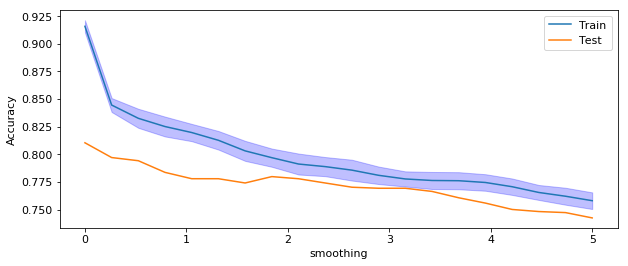

In [149]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(alphas,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')
print('There is a decrease in bias for lower alpha values, \nthe variance however becomes larger:')

We  set the `alpha` parameter to 3 for the best variance-bias tradeoff.. 

### Fit the final naive Bayes classifier to the training and test data

We now fit the final model to our training and test data

In [150]:
NB_adj_alpha = BernoulliNB(alpha = 3)

sentiment_NB_adj = NB_adj_alpha.fit(X_dev_vec_a.toarray(), np.array(y_dev_a)) 

print('Training Accuracy: ', A(sentiment_NB_adj, X_dev_vec_a.toarray(), np.array(y_dev_a)))
print('Test Accuracy: ', A(sentiment_NB_adj, X_test_vec_a.toarray(), np.array(y_test_a)))

Training Accuracy:  0.7844827586206896
Test Accuracy:  0.7633928571428571


In [151]:
#Put tokens and coefficients in one dataframe
feat_prob = pd.DataFrame(np.exp(sentiment_NB.feature_log_prob_).T)
feat_prob.columns = ['Negative', "Positive"]

#compute the ratio of probability of being predicted as a negative vs positive sentiment divided by the sum of probabilities
feat_prob_ratio_neg = (feat_prob['Negative']/feat_prob['Positive'])*(feat_prob['Negative'])
feat_prob_ratio_pos = (feat_prob['Positive']/feat_prob['Negative'])*(feat_prob['Positive'])

coef_tokens = pd.concat([pd.Series(tokens_b), feat_prob, feat_prob_ratio_neg, feat_prob_ratio_pos], axis = 1) 
coef_tokens.columns = ['Token', 'Negative', "Positive", "RatioNP", 'RatioPN']


#Sort

coef_tokens['highest'] = abs(coef_tokens[["RatioNP", "RatioPN"]]).max(axis=1)
coef_high = coef_tokens.sort_values('highest', ascending = False)
coef_high['color'] = (coef_high['RatioNP'] > coef_high['RatioPN']).replace([False, True], ['red', 'blue'])
coef_high_sorted_neg = coef_tokens.sort_values(['RatioNP'], ascending = False)
coef_high_sorted_pos = coef_tokens.sort_values(['RatioPN'], ascending = False)

#Print
print(coef_high.head(20))

                Token  Negative  Positive   RatioNP   RatioPN   highest color
1492           farver  0.256018  0.013536  4.842134  0.000716  4.842134  blue
2811            kende  0.763676  0.221658  2.631084  0.064337  2.631084  blue
1290            dyret  0.431072  0.079526  2.336629  0.014671  2.336629  blue
898       bremseklods  0.137856  0.008460  2.246292  0.000519  2.246292  blue
1519            feber  0.321663  0.052453  1.972550  0.008554  1.972550  blue
4888            smile  0.080963  0.003384  1.936995  0.000141  1.936995  blue
4206        produkter  0.391685  0.079526  1.929138  0.016147  1.929138  blue
3805       offentligt  0.584245  0.181049  1.885358  0.056104  1.885358  blue
5834       uopmærksom  0.628009  0.213198  1.849900  0.072377  1.849900  blue
2319            hevet  0.153173  0.516074  0.045462  1.738773  1.738773   red
2958       kontaktede  0.634573  0.245347  1.641282  0.094859  1.641282  blue
5332           tablet  0.273523  0.045685  1.637613  0.007631  1

Lets plot these:

1492             farver
2811              kende
1290              dyret
898         bremseklods
1519              feber
4888              smile
4206          produkter
3805         offentligt
5834         uopmærksom
2958         kontaktede
5332             tablet
658          belastning
1343               egen
1381            eminent
5037               spøg
3317    lækkert.absolut
1844      frekventerede
440            allerede
4104            pigerne
2319              hevet
Name: Token, dtype: object


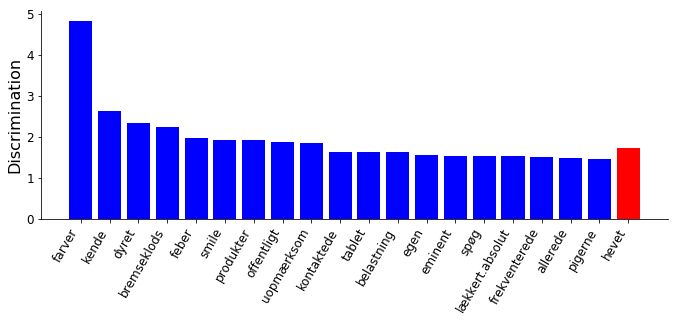

In [152]:
top_features = 20

top = coef_high.iloc[:top_features].sort_values(['RatioNP'], ascending = False)
colors = top['color']

barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top.highest, color = colors)
features = top.Token
plt.xticks(np.arange(0, top_features), features, rotation=60, ha='right')

ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Discrimination", fontsize=16)

print(features)
plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsEB_a.png')

<br><br>
## Implement a support vector classifier

First we naïvely fit the support vector classifier to the training data. We choose a value of 5 for the regularization parameter `C`. This is actually the inverse of the regularization strength so a lower value means stronger regularization. We use the `l1` penalty because we want to have a sparse solution (we want to set some coefficients to 0) for interpretation purposes.

In [153]:
#First we naïvely fit the model:
sentiment_svc_lib = svc_lib.fit(X_dev_vec_a, y_dev_a) 

#Investigate the accuracy of the training data
print('Training Accuracy: ', A(sentiment_svc_lib, X_dev_vec_a, np.array(y_dev_a))) 

Training Accuracy:  1.0


The accuracy value of the training data is very high and theremight be a large difference with the test data. Perhaps we should fit a learning curve to investigate the bias and variance of the model and see whether we are over/under fitting.

### Make a learning curve

In [154]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_lib,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [155]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

             Train      Test
sample size                 
93             1.0  0.781672
187            1.0  0.808440
281            1.0  0.825657
375            1.0  0.839109
469            1.0  0.832480


This learning plot has too much variance


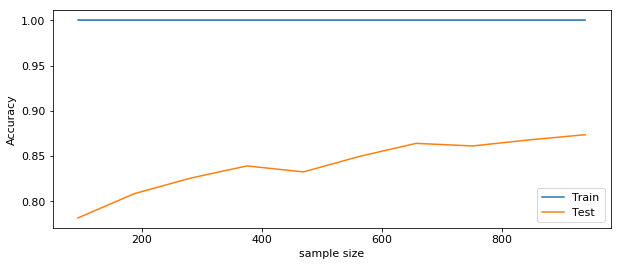

In [156]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('This learning plot has too much variance')

Because the learning curve shows a lot of variance we want to see whether we can optimize the regularization parameter of the support vector classifier. In particular we should consider setting the regularization parameter to a more conservative (thus lower) value.  We do this by making a validation curve plotting the training and test accuracy for several value of `C`.

### Make a validation curve

In [157]:
Cs = np.linspace(0.001, 5, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [158]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.435824  0.435814
0.264105        0.873351  0.852562
0.527211        0.919327  0.864961
0.790316        0.946254  0.880263
1.053421        0.964027  0.882177


Text(0,0.5,'Accuracy')

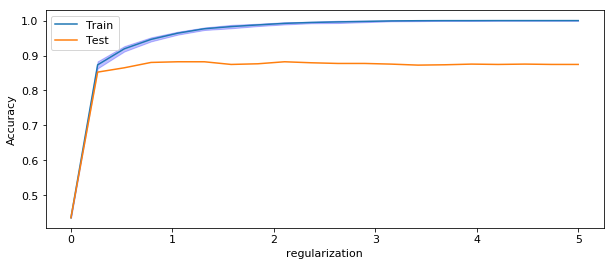

In [159]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We see that the average prediction accuracy (between training and test set) starts decreasing steeply after a `C` value of 0.3. Lets plot a more detailed validation curve for values lower than 0.3.

In [160]:
Cs = np.linspace(0.001, 0.3, 20)

train_scores_val, test_scores_val = \
    validation_curve(estimator= svc_lib,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     param_name='C',
                     param_range=Cs,
                     scoring=A,                 
                     cv=10)

In [161]:
acc_ = pd.DataFrame({'Train':train_scores_val.mean(axis=1),
                     'Test':test_scores_val.mean(axis=1)})\
        .set_index(pd.Index(Cs,name='regularization'))    
print(acc_.head())

                   Train      Test
regularization                    
0.001000        0.435824  0.435814
0.016737        0.564176  0.564186
0.032474        0.790974  0.784529
0.048211        0.811195  0.803678
0.063947        0.827372  0.818028


Text(0,0.5,'Accuracy')

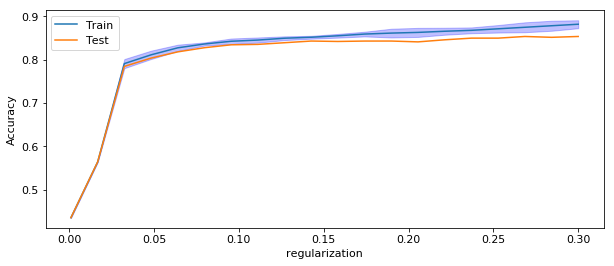

In [162]:
f_val, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(Cs,
                train_scores_val.mean(1) + train_scores_val.std(1)*1.96,
                train_scores_val.mean(1) - train_scores_val.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

We select a regularization setting `C` = 0.10 for which the test accuracy is still within the confidence bands of the training accuracy to see whether the learning curves improve.

### Make learning curve

In [163]:
svc_mod = LinearSVC(penalty = 'l1', C = 0.10, random_state = 1, dual = False)

In [164]:
train_sizes_learn, train_scores_learn, test_scores_learn = \
    learning_curve(estimator= svc_mod,
                     X=X_dev_vec_a,
                     y=y_dev_a,
                     train_sizes=np.linspace(0.1, 1.0, 10),
                     scoring=A,                 
                     cv=10)

In [165]:
acc_ = pd.DataFrame({'Train':train_scores_learn.mean(axis=1),
                     'Test':test_scores_learn.mean(axis=1)})\
        .set_index(pd.Index(train_sizes_learn,name='sample size'))    
print(acc_.head())

                Train      Test
sample size                    
93           0.559140  0.570853
187          0.652406  0.643657
281          0.786121  0.773092
375          0.801600  0.790382
469          0.818977  0.804640


Seems ok for our training size


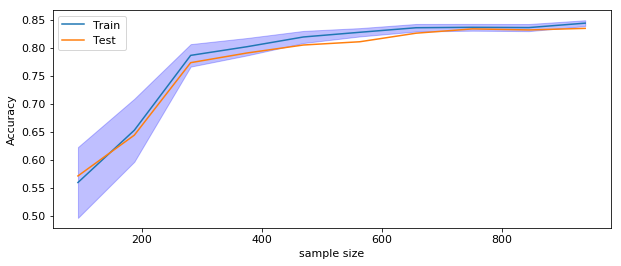

In [166]:
f_learn, ax = plt.subplots(figsize=(10,4))
acc_.plot(ax=ax)
ax.fill_between(train_sizes_learn,
                train_scores_learn.mean(1) + train_scores_learn.std(1)*1.96,
                train_scores_learn.mean(1) - train_scores_learn.std(1)*1.96, 
                alpha=0.25, 
                color='blue')
ax.set_ylabel('Accuracy')

print('Seems ok for our training size')

### Fit final support vector classification model to training and test data

We now fit the final model, with `C` = 0.10 to our training and test data.

In [167]:
sentiment_svc_mod = svc_mod.fit(X_dev_vec_a, y_dev_a)
print('Training Accuracy: ', A(sentiment_svc_mod, X_dev_vec_a, y_dev_a))
print('Test Accuracy: ', A(sentiment_svc_mod, X_test_vec_a, y_test_a))

Training Accuracy:  0.8448275862068966
Test Accuracy:  0.8013392857142857


The training and test accuracy are now much lower and closer together. We can now investigate the estimated coeficients to the test data to see which tokens predict positive and negative reviews.

In [168]:
#Put tokens and coefficients in one dataframe
coef_tokens = pd.concat([pd.Series(tokens_a), pd.DataFrame(sentiment_svc_mod.coef_.T)], axis = 1) 
coef_tokens.columns = ['Token', 'Coef']

#Count the amount of tokens with non-zero coefficient value
print((coef_tokens['Coef'] != 0).value_counts()) 

False    6927
True       14
Name: Coef, dtype: int64


In [169]:
coef_tokens = coef_tokens[coef_tokens.Coef != 0] #remove tokens with zero coefficient value
coef_tokens_sorted = coef_tokens.sort_values('Coef')#sort and print to get highest and lowest coefficients
print(coef_tokens_sorted[['Token', 'Coef']]) 


          Token      Coef
2811       ikke -4.271490
1492     dårlig -2.389095
658          at -1.752941
2958        jeg -0.848106
1381        det -0.461207
21            , -0.435910
0             ! -0.328631
36            . -0.326622
6514        var -0.205273
1327     dejlig  0.447503
916   betjening  0.681910
548       altid  1.030205
5772      super  1.204066
2319        god  3.286550


Lets plot these:

          Token      Coef
2811       ikke -4.271490
1492     dårlig -2.389095
658          at -1.752941
2958        jeg -0.848106
1381        det -0.461207
21            , -0.435910
0             ! -0.328631
36            . -0.326622
6514        var -0.205273
1327     dejlig  0.447503
916   betjening  0.681910
548       altid  1.030205
5772      super  1.204066
2319        god  3.286550


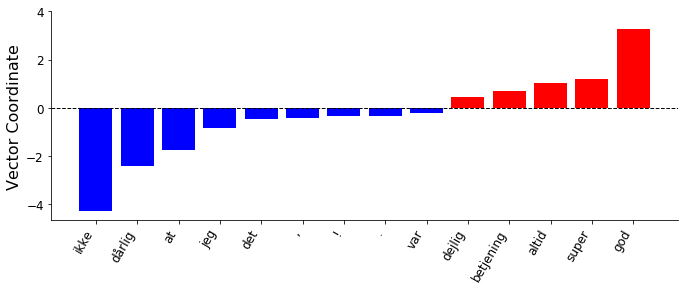

In [170]:
top_features = 14
top_features_p = 5
top_features_n = 9

top_pos_coef = coef_tokens_sorted.iloc[-top_features_p:]
top_neg_coef = coef_tokens_sorted.iloc[:top_features_n]
top = pd.concat([top_pos_coef, top_neg_coef], axis = 0).sort_values('Coef')
print(top)
colors = ['red' if c > 0 else 'blue' for c in top['Coef']]


barplot, ax = plt.subplots(figsize=(10,4))
plt.tight_layout()
plt.bar(np.arange(top_features), top['Coef'], color=colors)
features = np.array(top['Token'])
plt.xticks(np.arange(0, top_features), top['Token'], rotation=60, ha='right')
plt.yticks([ -4, -2, 0, 2, 4])
ax.spines['top'].set_visible(False) #remove borders
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.tick_params(top='off', right='off')#control tick marks
ax.axhline(y=0, xmin=0, xmax=20, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=12) #change size of tick labels
ax.set_ylabel("Vector Coordinate", fontsize=16)

plt.gcf().subplots_adjust(bottom=0.22, left = 0.1)
plt.savefig('CoefficientsSVC_a.png')